<a href="https://colab.research.google.com/github/Leonardo-Rocha/Dark-Covid-Net-PyTorch/blob/master/dark_covid_net_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# import torch.functional as F

import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold

Download dataset from github

In [82]:
!wget https://codeload.github.com/muhammedtalo/COVID-19/zip/master
!unzip /content/master 

--2020-07-20 00:23:49--  https://codeload.github.com/muhammedtalo/COVID-19/zip/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.2’

master.2                [              <=>   ] 398.37M  24.3MB/s    in 17s     

2020-07-20 00:24:06 (23.3 MB/s) - ‘master.2’ saved [417716858]

Archive:  /content/master
8c645fb9b2b5340e7381c6d1ef4e21f182bfa1d9
replace COVID-19-master/DarkCovidNet  for binary classes.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace COVID-19-master/DarkCovidNet model for three classes.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace COVID-19-master/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace COVID-19-master/X-Ray Image DataSet/Covid-19/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace COVID

In [83]:
def evaluate(dl, model, criterion):
    model.to(device)
    model.eval()
    lacc = []
    lloss = []
    with torch.no_grad():
        for x, y in dl:
            x = x.to(device)
            pred = model(x)
            loss = criterion(pred, y.to(device))
            y_pred = pred.argmax(dim=1).cpu()
            acc = metrics.accuracy_score(y, y_pred)
            lacc.append(acc)
            lloss.append(loss.item())
    return np.mean(lacc), np.mean(lloss)

In [84]:
def train_model(dl, model, opt, criterion, device):
    model.to(device)
    model.train()
    lloss = []
    for x, y in dl:
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
        lloss.append(loss.item())
    print(' Training Loss: ', np.mean(lloss))

In [85]:
def conv_block(ni, nf, size=3, stride=1):
    def for_pad(s): return s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False),
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True),
    )

In [86]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),
        conv_block(ni, nf)
    )

In [87]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [88]:
def data_split(dataset, lists):
    return [torch.utils.data.Subset(dataset, llist) for llist in lists]

In [89]:
class DarkCovidNet(nn.Module):
    def __init__(self):
        super(DarkCovidNet, self).__init__()
        self.backbone = nn.Sequential(
            conv_block(3, 8),
            maxpooling(),
            conv_block(8, 16),
            maxpooling(),
            triple_conv(16, 32),
            maxpooling(),
            triple_conv(32, 64),
            maxpooling(),
            triple_conv(64, 128),
            maxpooling(),
            triple_conv(128, 256),
            conv_block(256, 128, size=1),
            conv_block(128, 256),
            conv_block(256, 3),
            nn.Flatten(),
            nn.Linear(507, 3)
        )

    def forward(self, x):
        return self.backbone(x)

In [90]:
NUM_SPLITS = 5
MAX_EPOCHS = 10
dataset_dir = '/content/COVID-19-master/X-Ray Image DataSet/'

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [91]:
dataset = datasets.ImageFolder(dataset_dir, transform=transform)
labels = [line[-1] for line in dataset.imgs]

print(f'{dataset_dir}: ', end='')
print(dataset.classes)

/content/COVID-19-master/X-Ray Image DataSet/: ['Covid-19', 'No_findings', 'Pneumonia']


In [92]:
device = torch.device(
    'cuda') if torch.cuda.is_available() else torch.device('cpu')

print(f'Executing on {device}')
dl = DataLoader(dataset, batch_size=32, shuffle=True)

data, class_att = next(iter(dl))

Executing on cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


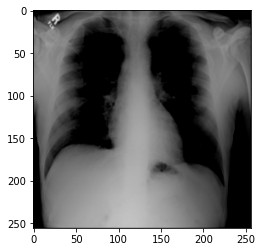

In [93]:
plt.imshow(data[0].permute(1, 2, 0))

In [94]:
model = DarkCovidNet()
model.to(device)

criterion = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)

skf = StratifiedKFold(n_splits=NUM_SPLITS)

In [ ]:
best_acc = 0
num_fold = 0
lacc = []
for train_index, test_index in skf.split(range(len(dataset.imgs)), labels):
    print(f'Fold {num_fold}:')

    ds_train, ds_test = data_split(dataset, (train_index, test_index))

    n = len(ds_train)
    n_train = int(n*0.8)
    n_dev = n - n_train
    ds_train, ds_dev = torch.utils.data.random_split(
        ds_train, (n_train, n_dev))

    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=300)
    dl_dev = torch.utils.data.DataLoader(ds_dev, batch_size=300)
    dl_test = torch.utils.data.DataLoader(ds_test, batch_size=300)

    learly_stop_acc = 0.0
    best_count = 0
    epoch = 0

    while best_count < 10:
      print(f'Epoch {epoch}')
      train_model(dl_train, model, opt, criterion, device)
      (acc, loss) = evaluate(dl_dev, model, criterion)
      epoch += 1
      if acc > learly_stop_acc:
        learly_stop_acc = acc
        best_count = -1
      best_count += 1
      if epoch >= MAX_EPOCHS:
        break

    (acc, loss) = evaluate(dl_dev, model, criterion)
    print("Valuation:\n\tAccuracy: %4.3f Loss: %4.3f" % (acc, loss))
    if acc > best_acc:
      torch.save(model.state_dict(),'model.pth')
      best_acc = acc
    lacc.append(acc)

print("\nMean Accuracy: %4.3f +/- %4.3f" % (np.mean(lacc), np.std(lacc)))

Fold 0:
Epoch 0
 Training Loss:  0.9994769891103109
Epoch 1
 Training Loss:  0.8242617249488831
Epoch 2
 Training Loss:  0.7403738498687744
Epoch 3
 Training Loss:  0.6649618744850159
Epoch 4
 Training Loss:  0.5907556017239889
Epoch 5
 Training Loss:  0.5882736444473267
Epoch 6
 Training Loss:  0.6097603042920431
Epoch 7
 Training Loss:  0.49978283047676086
Epoch 8
 Training Loss:  0.38121432065963745
Epoch 9
 Training Loss:  0.3617979238430659
